# DATA 620 - Assignment 5

Jeremy OBrien, Mael Illien, Vanita Thompson

* Choose a corpus of interest. 
* How many total unique words are in the corpus? (Please feel free to define unique words in any interesting, defensible way). 
* Taking the most common words, how many unique words represent half of the total words in the corpus
* Identify the 200 highest frequency words in this corpus. 
* Create a graph that shows the relative frequency of these 200 words. 
* Does the observed relative frequency of these words follow Zipf’s law? Explain.  
* In what ways do you think the frequency of the words in this corpus differ from “all words in all corpora.”  



## Setup

In [39]:
import nltk, re, pprint
import matplotlib.pyplot as plt
from nltk import word_tokenize

## Data Import

In [3]:
path = nltk.data.find('corpora/gutenberg/melville-moby_dick.txt')
raw = open(path, 'r').read()

## Data Exploration and Analysis

In [30]:
tokens = word_tokenize(raw)
len(tokens)
text = nltk.Text(tokens)

In [31]:
print('{} tokens'.format(len(tokens)))

255038 tokens


In [32]:
words = [w.lower() for w in tokens if w.isalpha()]

In [33]:
vocab = sorted(set(words))
print('{} unique words'.format(len(vocab)))

16510 unique words


In [36]:
fdist = nltk.FreqDist(words)
fdist.most_common(200)
# remove stopwords

[('the', 14422),
 ('of', 6586),
 ('and', 6414),
 ('a', 4698),
 ('to', 4597),
 ('in', 4163),
 ('that', 3081),
 ('his', 2530),
 ('it', 2508),
 ('i', 2113),
 ('he', 1890),
 ('but', 1813),
 ('is', 1748),
 ('as', 1741),
 ('with', 1722),
 ('was', 1651),
 ('for', 1616),
 ('all', 1508),
 ('this', 1393),
 ('at', 1318),
 ('not', 1218),
 ('by', 1201),
 ('from', 1088),
 ('whale', 1086),
 ('him', 1067),
 ('on', 1060),
 ('so', 1059),
 ('be', 1042),
 ('one', 912),
 ('you', 891),
 ('there', 861),
 ('now', 784),
 ('had', 779),
 ('have', 771),
 ('or', 713),
 ('were', 683),
 ('they', 667),
 ('which', 648),
 ('me', 630),
 ('then', 627),
 ('their', 620),
 ('some', 618),
 ('when', 606),
 ('what', 603),
 ('are', 597),
 ('an', 596),
 ('my', 588),
 ('no', 583),
 ('like', 580),
 ('upon', 565),
 ('out', 527),
 ('into', 522),
 ('up', 514),
 ('ahab', 508),
 ('more', 507),
 ('man', 490),
 ('if', 481),
 ('them', 474),
 ('ship', 463),
 ('we', 455),
 ('old', 443),
 ('ye', 438),
 ('would', 435),
 ('do', 419),
 ('been',

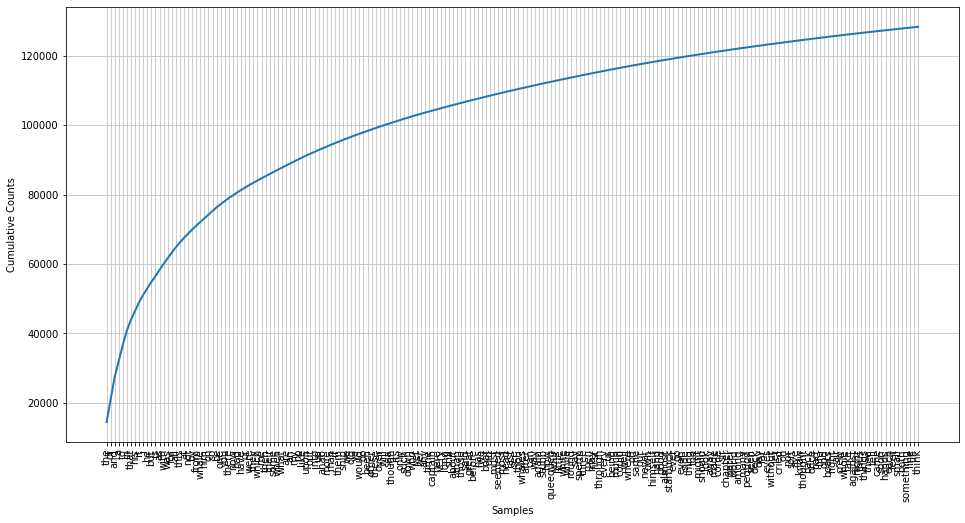

In [40]:
plt.rcParams["figure.figsize"] = (16,8)
fdist.plot(200, cumulative=True)

Zipf's law states that given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table.

## Visualization

## Conclusion

## Youtube